# Preprocess WAVs into MFC JPEGs
MFC stands for mel-frequency cepstrum.

## Import packages

In [6]:
import os
import json
from tqdm import tqdm_notebook

import numpy as np
import scipy.io.wavfile
import librosa
import matplotlib.pyplot as plt
from skimage.transform import resize
import scipy.misc

import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd

## Setup

### Obtain filenames of WAVs

The directory holding all the WAV files and the path to their metadata:

In [7]:
wav_dir = '../../AudioMNIST/data' 
meta_fpath = f'{wav_dir}/audioMNIST_meta.txt'

In [8]:
with open(meta_fpath) as json_f:
    meta = json.load(json_f)

wav_dir has the following folder structure:
- 1
    - 1_01_0.wav
    - 1_01_1.wav
    - 1_01_2.wav
    - ...
    - 9_01_49.wav
- ...
- 60
    - 1_60_0.wav
    - ...
    - 0_60_49.wav
- audioMNIST_meta.txt

Loop over each participant in metadata and append its index to either male_idxs or female_idxs.

In [9]:
male_idxs, female_idxs = [], []
for idx, info in meta.items():
    if info['gender'].lower() == 'male':
        male_idxs.append(idx)
    elif info['gender'].lower() == 'female':
        female_idxs.append(idx)

This function takes in a list of participant indicies and concatenate the relative paths to their WAVs into a single list.

In [10]:
def get_wav_fpaths_from_participant_indices(idxs):
    wav_fpaths = []
    for idx in idxs:
        for fname in os.listdir(f'{wav_dir}/{idx}'):
            wav_fpaths.append(f'{wav_dir}/{idx}/{fname}')
    return wav_fpaths

<div style="text-align: justify">
First sorting the wav_fpaths and then shuffling them using a random seed ensures that the order of wav_fpaths is the same across all platforms, as long as the Python sorting rule is the same. This is very important for reproducibility.
</div>

In [11]:
male_wav_fpaths = sorted(get_wav_fpaths_from_participant_indices(male_idxs))
female_wav_fpaths = sorted(get_wav_fpaths_from_participant_indices(female_idxs))

In [12]:
np.random.seed(25)
np.random.shuffle(male_wav_fpaths)
np.random.shuffle(female_wav_fpaths)

In [13]:
wav_fpaths = male_wav_fpaths + female_wav_fpaths

<div style="text-align: justify">
Quick sanity check:
</div>

In [14]:
ipd.Audio(male_wav_fpaths[666])

In [15]:
ipd.Audio(female_wav_fpaths[999])

### Define utility functions

<div style="text-align: justify">
It is natural that recordings have different lengths. Unfortunately, a convolutional neural network can only process inputs of the same dimensions. Therefore, we need to zero-pad all the recordings to the same length - the length of the longest recording.
</div>

In [16]:
def pad_signal(signal, target_len):
    
    num_zeros_needed = target_len - len(signal)
    
    if num_zeros_needed > 0:

        num_zeros_front = np.random.randint(num_zeros_needed)
        num_zeros_back = num_zeros_needed - num_zeros_front
        return np.pad(signal, (num_zeros_front, num_zeros_back), mode='constant')

    else: return signal

<div style="text-align: justify">
    "Pre-emphasis is the first part of <i>a noise reduction technique</i> in which a signal's weaker, higher frequencies are boosted before they are transmitted or recorded onto a storage medium." From more information, see <a href="https://wiki.hydrogenaud.io/index.php?title=Pre-emphasis">Hydrogenaudio Wiki: Pre-emphasis</a>.
</div>

In [17]:
kPRE_EMPHASIS_COEFF = 0.97

In [18]:
def pre_emphasis(signal):
    first_amp = signal[0]
    all_amps_without_first = signal[1:]
    all_amps_without_last = signal[:-1]
    emphasized_signal = np.append(first_amp, all_amps_without_first - kPRE_EMPHASIS_COEFF * all_amps_without_last)
    return emphasized_signal

In [19]:
def pipeline(signal):
    
    emphasized_signal = pre_emphasis(signal)
    
    # the following code applies dft, mel filter banks, logging, dct and normalization all at once
    # truly convenient
    
    lifted_mfcc = librosa.feature.mfcc(
        y=emphasized_signal.astype(float), 
        sr=sample_rate, 
        n_mfcc=12, 
        dct_type=2, 
        norm='ortho', 
        lifter=22,
        n_fft = int(sample_rate * 0.025),
        hop_length= int(sample_rate * 0.01),
        power=2,
        center=False,
        window='hanning',
        n_mels=40
    )

    return lifted_mfcc

### Obtain max length

In [20]:
sample_rate = librosa.core.get_samplerate(wav_fpaths[0])

In [21]:
sample_rate

48000

In [22]:
def get_max_duration(filenames):
    """
    Return the maximum duration in seconds for a group of wav files.
    This is much faster than loading all the wav files into numpy arrays and using the shape attribute.
    """
    max_duration = 0
    for fn in tqdm_notebook(filenames):
        duration = librosa.core.audio.get_duration(filename=fn)
        if duration > max_duration:
            max_duration = duration
    return max_duration

In [23]:
# this takes a while to run, so I've copied its output in the cell below for convenience
# max_duration = get_max_duration(wav_fpaths)

In [24]:
max_duration = 0.9999583333333333

In [27]:
max_samples = int(max_duration * sample_rate)

In [28]:
max_samples

47998

## Test the preprocessing pipeline

In [29]:
np.random.seed(32)  # determine how pad_signal pad signal
_, signal = scipy.io.wavfile.read(male_wav_fpaths[0])
signal = pad_signal(signal, target_len=max_samples)

(12, 98)
(224, 224, 3)
255 0 31.582071109693878


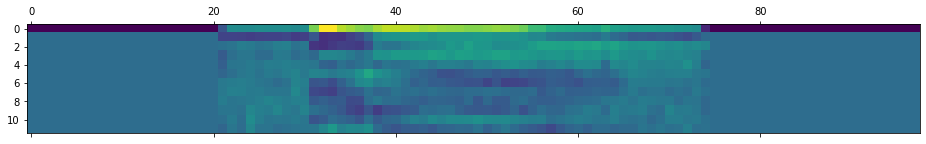

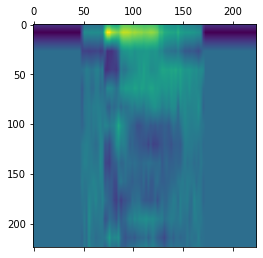

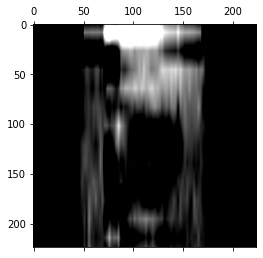

In [33]:
mfc = pipeline(signal)
print(mfc.shape)

mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))
print(mfc_3d.shape)  
# a pre-trained ResNet-34 uses an input shape of 3 (channel) * 224 * 244
# however, in order to save an image in RGB format, its shape has to be 224 * 224 * 3
# during model training, reshaping images from 224 * 224 * 3 to 3 * 224 * 224 will be taken care of

mfc_img = scipy.misc.toimage(mfc_3d, cmin=0, cmax=255)
print(np.array(mfc_img).max(), np.array(mfc_img).min(), np.array(mfc_img).mean())

plt.matshow(mfc)
plt.matshow(mfc_3d[:,:,2])  # the second channel; the first and the third channel look exactly the same
plt.matshow(mfc_img)
plt.show()

## Output MFC JPEGs

### Define target dir

In [46]:
dataset_dir = '../mfc_dataset'

### For male

Create a one-to-one mapping between MFC JPEG names and WAV names. This dictionary will be used in model evaluation.

In [56]:
male_idxs_to_wav_fpaths = {}
for i, fp in tqdm_notebook(enumerate(male_wav_fpaths), total=len(male_wav_fpaths)):
    male_idxs_to_wav_fpaths[f'{dataset_dir}/male_{i}.jpg'] = fp

In [57]:
with open('../maps/male_idxs_to_wav_fpaths.json', 'w+') as json_f:
    json.dump(male_idxs_to_wav_fpaths, json_f)

Generate MPC JPEGs.

In [ ]:
np.random.seed(1)  # determine how pad_signal pad signals
for i, fp in tqdm_notebook(enumerate(male_wav_fpaths), total=len(male_wav_fpaths)):
    _, signal = scipy.io.wavfile.read(fp)  # faster than librosa
    signal = pad_signal(signal, target_len=max_samples)
    mfc = pipeline(signal)
    mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))
    scipy.misc.toimage(mfc_3d, cmin=0, cmax=255).save(f'{dataset_dir}/male_{i}.jpg')

### For female

<div style="text-align: justify">
Create a one-to-one mapping between MFC JPEG names and WAV names. This dictionary will be used in model evaluation.
</div>

In [58]:
female_idxs_to_wav_fpaths = {}
for i, fp in tqdm_notebook(enumerate(female_wav_fpaths), total=len(female_wav_fpaths)):
    female_idxs_to_wav_fpaths[f'{dataset_dir}/female_{i}.jpg'] = fp

In [59]:
with open('../maps/female_idxs_to_wav_fpaths.json', 'w+') as json_f:
    json.dump(female_idxs_to_wav_fpaths, json_f)

Generate MPC JPEGs.

In [60]:
np.random.seed(2)  # determine how pad_signal pad signals
for i, fp in tqdm_notebook(enumerate(female_wav_fpaths), total=len(female_wav_fpaths)):
    _, signal = scipy.io.wavfile.read(fp)  # faster than librosa
    signal = pad_signal(signal, target_len=max_samples)
    mfc = pipeline(signal)
    mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))
    scipy.misc.toimage(mfc_3d, cmin=0, cmax=255).save(f'{dataset_dir}/female_{i}.jpg')